In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# Download the test dataset
!gdown --id 1SimoYHYu-4W0sVIVrRXIbha1r70WObi_
!unzip -q /content/test_set.zip -d test_Dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SimoYHYu-4W0sVIVrRXIbha1r70WObi_
To: /content/test_set.zip
100% 10.2M/10.2M [00:00<00:00, 34.1MB/s]


In [ ]:
# street weights download
!gdown --id 1FgGeLiDC_20SzpUatnBSqR_Oxed-2zGZ

# segment weights download
!gdown --id 1dahIi4LsJvQvVPbYKHyuO1jlX_tPef3I

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FgGeLiDC_20SzpUatnBSqR_Oxed-2zGZ
To: /content/street_detection_weights.pt
100% 5.54M/5.54M [00:00<00:00, 39.1MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1dahIi4LsJvQvVPbYKHyuO1jlX_tPef3I
To: /content/weights.pt
100% 6.03M/6.03M [00:00<00:00, 43.5MB/s]


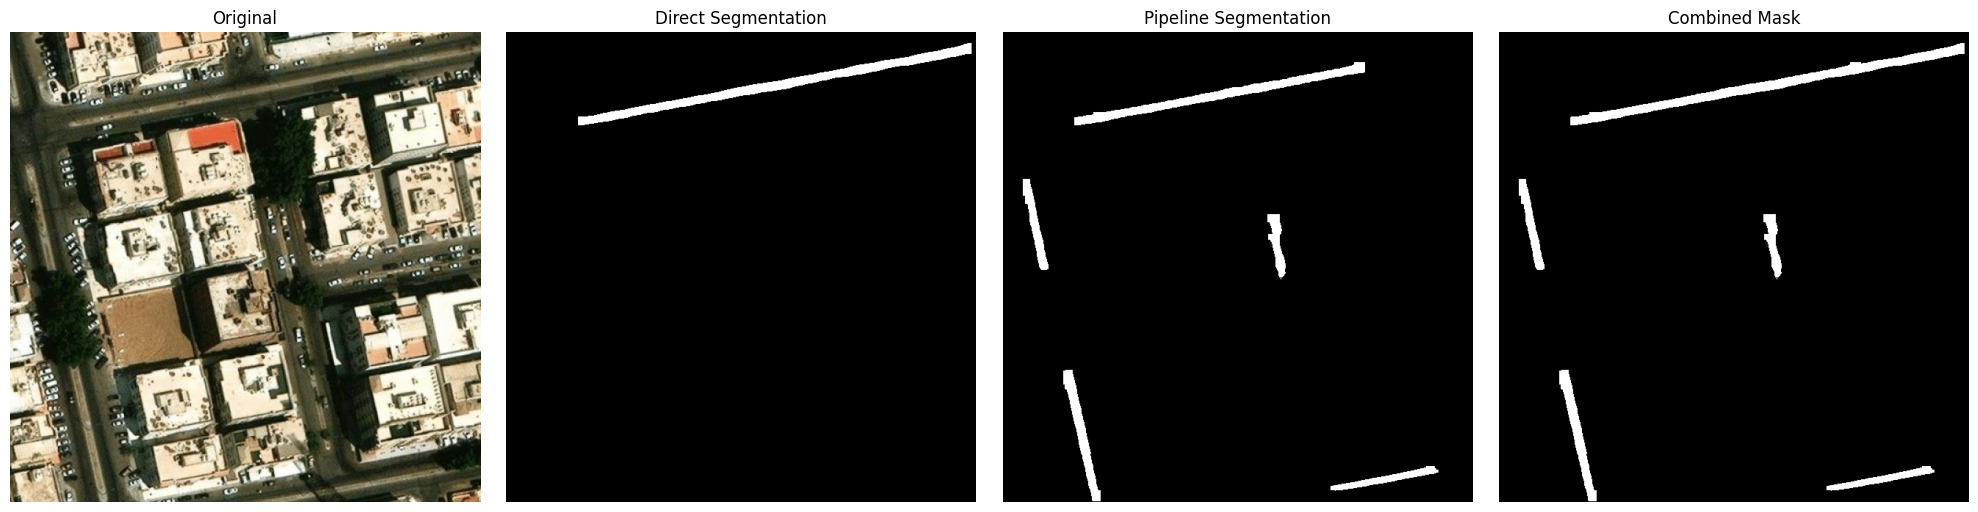

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import contextlib
import io

# =============================
# ✅ CONFIG
# =============================
image_path = "/content/test_Dataset/test_set/images/testImage_png.rf.92af4d03328db9fb41807c2d61c06b4d.jpg"
segmentation_model = YOLO('/content/weights.pt')
detection_model = YOLO('/content/street_detection_weights.pt')
segmentation_model.verbose = False
detection_model.verbose = False

# =============================
# ✅ Letterbox Function
# =============================
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    shape = img.shape[:2]
    ratio = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(round(shape[1] * ratio)), int(round(shape[0] * ratio)))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2
    img_resized = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return img_padded, dw, dh

# =============================
# ✅ PROCESS IMAGE
# =============================
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# --- Direct Segmentation
with contextlib.redirect_stdout(io.StringIO()):
    result_direct = segmentation_model(img, verbose=False)[0]
soft_mask_direct = np.zeros((h, w), dtype=np.float32)
mask_direct = np.zeros((h, w), dtype=np.uint8)
if result_direct.masks is not None and len(result_direct.masks.data) > 0:
    m = result_direct.masks.data[0].cpu().numpy()
    soft_mask_direct = cv2.resize(m, (w, h))
    mask_direct = (soft_mask_direct > 0.2).astype(np.uint8)

# --- Detection + Segmentation
full_labeled_mask = np.zeros((h, w), dtype=np.uint8)
soft_full_mask = np.zeros((h, w), dtype=np.float32)

with contextlib.redirect_stdout(io.StringIO()):
    results = detection_model(image_path, verbose=False)
detections = results[0].boxes.data
filtered_detections = detections[detections[:, 4] >= 0.2]

for det in filtered_detections:
    x1, y1, x2, y2, conf, class_id = map(int, det[:6])
    crop_img = img_rgb[y1:y2, x1:x2]
    if crop_img.shape[0] == 0 or crop_img.shape[1] == 0:
        continue
    crop_padded, dw, dh = letterbox(crop_img)
    crop_tensor = torch.from_numpy(crop_padded).float() / 255.0
    crop_tensor = crop_tensor.permute(2, 0, 1).unsqueeze(0)

    with torch.no_grad():
        with contextlib.redirect_stdout(io.StringIO()):
            seg_result = segmentation_model(crop_tensor, verbose=False)[0]

    if seg_result.masks is None or len(seg_result.masks.data) == 0:
        continue

    for m in seg_result.masks.data:
        raw_mask = m.cpu().numpy()
        dh, dw = int(dh), int(dw)
        h_slice = slice(max(0, dh), min(640, 640 - dh))
        w_slice = slice(max(0, dw), min(640, 640 - dw))
        raw_mask = raw_mask[h_slice, w_slice]
        if raw_mask.shape[0] == 0 or raw_mask.shape[1] == 0:
            continue
        soft_crop_resized = cv2.resize(raw_mask, (crop_img.shape[1], crop_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        soft_full_mask[y1:y2, x1:x2] = np.maximum(soft_full_mask[y1:y2, x1:x2], soft_crop_resized)
        full_labeled_mask[y1:y2, x1:x2] = np.maximum(full_labeled_mask[y1:y2, x1:x2], (soft_crop_resized > 0.2).astype(np.uint8))

# --- Combined Mask
combined_soft_mask = np.maximum(soft_mask_direct, soft_full_mask)
combined_binary_mask = (combined_soft_mask > 0.2).astype(np.uint8)

# =============================
# ✅ VISUALIZATION
# =============================
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask_direct, cmap='gray')
plt.title("Direct Segmentation")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(full_labeled_mask, cmap='gray')
plt.title("Pipeline Segmentation")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(combined_binary_mask, cmap='gray')
plt.title("Combined Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


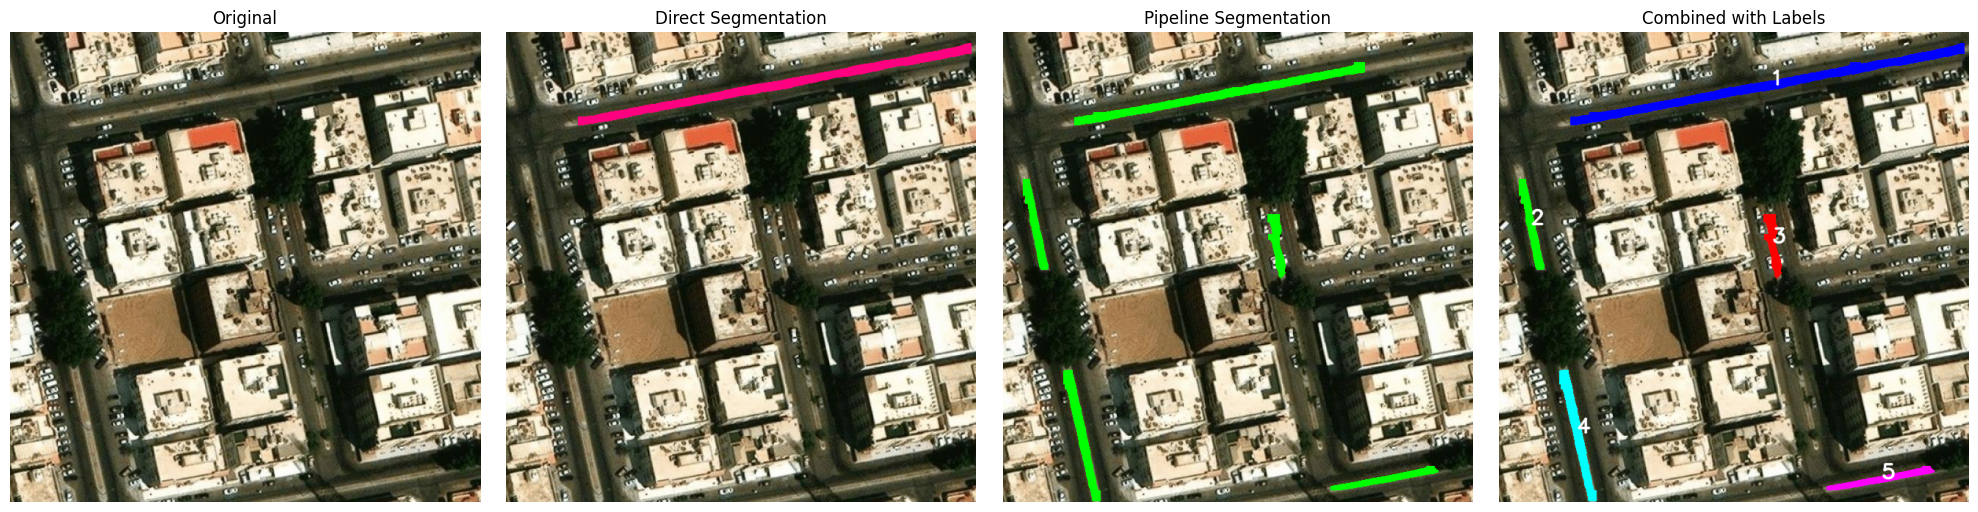

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from scipy.ndimage import label
import contextlib
import io

# =============================
# ✅ CONFIG
# =============================
image_path = "/content/test_Dataset/test_set/images/testImage_png.rf.92af4d03328db9fb41807c2d61c06b4d.jpg"
segmentation_model = YOLO('/content/weights.pt')
detection_model = YOLO('/content/street_detection_weights.pt')
segmentation_model.verbose = False
detection_model.verbose = False

# =============================
# ✅ Utility Functions
# =============================
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    shape = img.shape[:2]
    ratio = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(round(shape[1] * ratio)), int(round(shape[0] * ratio)))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2
    img_resized = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return img_padded, dw, dh

def solid_color_overlay(image, binary_mask, color):
    output = image.copy()
    ys, xs = np.where(binary_mask == 1)
    for c in range(3):
        output[ys, xs, c] = color[c]
    return output

# =============================
# ✅ Load Image
# =============================
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# --- Direct Segmentation
with contextlib.redirect_stdout(io.StringIO()):
    result_direct = segmentation_model(img, verbose=False)[0]
soft_mask_direct = np.zeros((h, w), dtype=np.float32)
mask_direct = np.zeros((h, w), dtype=np.uint8)
if result_direct.masks is not None and len(result_direct.masks.data) > 0:
    m = result_direct.masks.data[0].cpu().numpy()
    soft_mask_direct = cv2.resize(m, (w, h))
    mask_direct = (soft_mask_direct > 0.2).astype(np.uint8)

# --- Detection + Segmentation
full_labeled_mask = np.zeros((h, w), dtype=np.uint8)
soft_full_mask = np.zeros((h, w), dtype=np.float32)

with contextlib.redirect_stdout(io.StringIO()):
    results = detection_model(image_path, verbose=False)
detections = results[0].boxes.data
filtered_detections = detections[detections[:, 4] >= 0.2]

for det in filtered_detections:
    x1, y1, x2, y2, conf, class_id = map(int, det[:6])
    crop_img = img_rgb[y1:y2, x1:x2]
    if crop_img.shape[0] == 0 or crop_img.shape[1] == 0:
        continue
    crop_padded, dw, dh = letterbox(crop_img)
    crop_tensor = torch.from_numpy(crop_padded).float() / 255.0
    crop_tensor = crop_tensor.permute(2, 0, 1).unsqueeze(0)

    with torch.no_grad():
        with contextlib.redirect_stdout(io.StringIO()):
            seg_result = segmentation_model(crop_tensor, verbose=False)[0]

    if seg_result.masks is None or len(seg_result.masks.data) == 0:
        continue

    for m in seg_result.masks.data:
        raw_mask = m.cpu().numpy()
        dh, dw = int(dh), int(dw)
        h_slice = slice(max(0, dh), min(640, 640 - dh))
        w_slice = slice(max(0, dw), min(640, 640 - dw))
        raw_mask = raw_mask[h_slice, w_slice]
        if raw_mask.shape[0] == 0 or raw_mask.shape[1] == 0:
            continue
        soft_crop_resized = cv2.resize(raw_mask, (crop_img.shape[1], crop_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        soft_full_mask[y1:y2, x1:x2] = np.maximum(soft_full_mask[y1:y2, x1:x2], soft_crop_resized)
        full_labeled_mask[y1:y2, x1:x2] = np.maximum(full_labeled_mask[y1:y2, x1:x2], (soft_crop_resized > 0.2).astype(np.uint8))

# --- Combined Mask
combined_soft_mask = np.maximum(soft_mask_direct, soft_full_mask)
combined_binary_mask = (combined_soft_mask > 0.2).astype(np.uint8)

# =============================
# ✅ Generate Colored Outputs
# =============================
# 1. Solid Direct Segmentation
color_direct = (128, 0, 255)
solid_direct = solid_color_overlay(img.copy(), mask_direct, color_direct)

# 2. Solid Pipeline Segmentation
color_pipeline = (0, 255, 0)
solid_pipeline = solid_color_overlay(img.copy(), full_labeled_mask, color_pipeline)

# 3. Combined with Labels
labeled_mask, num_features = label(combined_binary_mask)
predefined_colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (255, 0, 255), (0, 255, 255),
    (255, 165, 0), (128, 0, 128), (0, 128, 128),
    (0, 0, 0)
]

colored_combined = img.copy()
for region_id in range(1, num_features + 1):
    ys, xs = np.where(labeled_mask == region_id)
    if len(xs) == 0 or len(ys) == 0:
        continue
    color = predefined_colors[(region_id - 1) % len(predefined_colors)]
    for c in range(3):
        colored_combined[ys, xs, c] = color[c]
    cx, cy = int(np.mean(xs)), int(np.mean(ys))
    cv2.putText(colored_combined, str(region_id), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX,
                0.9, (255, 255, 255), 2, cv2.LINE_AA)

# Convert to RGB for matplotlib
solid_direct_rgb = cv2.cvtColor(solid_direct, cv2.COLOR_BGR2RGB)
solid_pipeline_rgb = cv2.cvtColor(solid_pipeline, cv2.COLOR_BGR2RGB)
colored_combined_rgb = cv2.cvtColor(colored_combined, cv2.COLOR_BGR2RGB)

# =============================
# ✅ Final Visualization
# =============================
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(solid_direct_rgb)
plt.title("Direct Segmentation")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(solid_pipeline_rgb)
plt.title("Pipeline Segmentation")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(colored_combined_rgb)
plt.title("Combined with Labels")
plt.axis('off')

plt.tight_layout()
plt.show()
